# Deploying AI
## Assignment 1: Evaluating Summaries

A key application of LLMs is to summarize documents. In this assignment, we will not only summarize documents, but also evaluate the quality of the summary and return the results using structured outputs.

**Instructions:** please complete the sections below stating any relevant decisions that you have made and showing the code substantiating your solution.

## Select a Document

Please select one out of the following articles:

+ [Managing Oneself, by Peter Druker](https://www.thecompleteleader.org/sites/default/files/imce/Managing%20Oneself_Drucker_HBR.pdf)  (PDF)
+ [The GenAI Divide: State of AI in Business 2025](https://www.artificialintelligence-news.com/wp-content/uploads/2025/08/ai_report_2025.pdf) (PDF)
+ [What is Noise?, by Alex Ross](https://www.newyorker.com/magazine/2024/04/22/what-is-noise) (Web)

# Load Secrets

In [1]:
%load_ext dotenv
%dotenv ../05_src/.secrets

## Load Document

Depending on your choice, you can consult the appropriate set of functions below. Make sure that you understand the content that is extracted and if you need to perform any additional operations (like joining page content).

### PDF

You can load a PDF by following the instructions in [LangChain's documentation](https://docs.langchain.com/oss/python/langchain/knowledge-base#loading-documents). Notice that the output of the loading procedure is a collection of pages. You can join the pages by using the code below.

```python
document_text = ""
for page in docs:
    document_text += page.page_content + "\n"
```

### Web

LangChain also provides a set of web loaders, including the [WebBaseLoader](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base). You can use this function to load web pages.

In [2]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "https://www.artificialintelligence-news.com/wp-content/uploads/2025/08/ai_report_2025.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

document_text = ""
for page in docs:
    document_text += page.page_content + "\n"


## Generation Task

Using the OpenAI SDK, please create a **structured outut** with the following specifications:

+ Use a model that is NOT in the GPT-5 family.
+ Output should be a Pydantic BaseModel object. The fields of the object should be:

    - Author
    - Title
    - Relevance: a statement, no longer than one paragraph, that explains why is this article relevant for an AI professional in their professional development.
    - Summary: a concise and succinct summary no longer than 1000 tokens.
    - Tone: the tone used to produce the summary (see below).
    - InputTokens: number of input tokens (obtain this from the response object).
    - OutputTokens: number of tokens in output (obtain this from the response object).
       
+ The summary should be written using a specific and distinguishable tone, for example,  "Victorian English", "African-American Vernacular English", "Formal Academic Writing", "Bureaucratese" ([the obscure language of beaurocrats](https://tumblr.austinkleon.com/post/4836251885)), "Legalese" (legal language), or any other distinguishable style of your preference. Make sure that the style is something you can identify. 
+ In your implementation please make sure to use the following:

    - Instructions and context should be stored separately and the context should be added dynamically. Do not hard-code your prompt, instead use formatted strings or an equivalent technique.
    - Use the developer (instructions) prompt and the user prompt.


In [4]:
from pydantic import BaseModel, Field
from openai import OpenAI

class ArticleSummary(BaseModel):
    author: str = Field(description="The author(s) of the article")
    title: str = Field(description="The title of the article")
    relevance: str = Field(
        description="A paragraph explaining why this article is relevant for AI professionals"
    )
    summary: str = Field(
        description="A concise summary of the article (max 1000 tokens)"
    )
    tone: str = Field(
        description="The tone/style used to write the summary"
    )
    input_tokens: int = Field(description="Number of input tokens used")
    output_tokens: int = Field(description="Number of output tokens generated")
    

def summarize_article(article_text: str, tone: str) -> ArticleSummary:
   
    from langchain_openai import ChatOpenAI
    
    # Initialize LangChain model
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    # Create structured output LLM
    structured_llm = llm.with_structured_output(ArticleSummary)
    
    # Developer/system instructions (stored separately)
    system_instructions = """You are an expert article analyst specializing in AI and technology content.
Your task is to summarize articles and provide insights for AI professionals.

When summarizing articles, you must:
1. Identify the author and title accurately
2. Explain the relevance to AI professionals' career development
3. Write a summary in the specified tone/style
4. Keep summaries concise (under 1000 tokens)
5. Ensure the tone is distinctive and consistent throughout the summary"""

    # User prompt with dynamic context
    user_prompt = f"""Please summarize the following article for an AI professional audience.

**Writing Style Required:** {tone}

Make sure your summary is written entirely in {tone} style - this should be clearly identifiable and consistent throughout.

**Article Text:**
{article_text}

Provide:
- Author name(s)
- Article title  
- Why this is relevant for AI professionals (one paragraph)
- A summary written in {tone} style (max 1000 tokens)
- The tone you used"""

    # Create messages
    from langchain_core.messages import SystemMessage, HumanMessage
    
    messages = [
        SystemMessage(content=system_instructions),
        HumanMessage(content=user_prompt)
    ]
    
    # Invoke with structured output
    response = structured_llm.invoke(messages)
    
    # Use callback to capture token usage
    from langchain_community.callbacks import get_openai_callback
    
    with get_openai_callback() as cb:
        response = structured_llm.invoke(messages)
        
        # Capture actual token counts from callback
        response.input_tokens = cb.prompt_tokens
        response.output_tokens = cb.completion_tokens
    
    return response


In [5]:

result = summarize_article(document_text, tone="Formal Academic Writing")
import json
print(json.dumps(result.model_dump(), indent=2))

{
  "author": "Aditya Challapally, Chris Pease, Ramesh Raskar, Pradyumna Chari",
  "title": "The GenAI Divide: State of AI in Business 2025",
  "relevance": "This article is highly pertinent to AI professionals as it elucidates the current landscape of generative AI (GenAI) adoption within various enterprises. It highlights the stark contrast between the high levels of GenAI tool adoption and the lack of substantial transformation in business outcomes, referred to as the 'GenAI Divide.' By identifying key barriers to successful implementation and detailing the characteristics of organizations that effectively cross this divide, AI professionals can glean insights into strategies for enhancing AI deployment in their own organizations. Furthermore, the article emphasizes the importance of adaptive learning systems and the need for AI tools to integrate seamlessly into existing workflows, which are critical considerations for professionals in the field.",
  "summary": "The article 'The Ge

# Evaluate the Summary

Use the DeepEval library to evaluate the **summary** as follows:

+ Summarization Metric:

    - Use the [Summarization metric](https://deepeval.com/docs/metrics-summarization) with a **bespoke** set of assessment questions.
    - Please use, at least, five assessment questions.

+ G-Eval metrics:

    - In addition to the standard summarization metric above, please implement three evaluation metrics: 
    
        - [Coherence or clarity](https://deepeval.com/docs/metrics-llm-evals#coherence)
        - [Tonality](https://deepeval.com/docs/metrics-llm-evals#tonality)
        - [Safety](https://deepeval.com/docs/metrics-llm-evals#safety)

    - For each one of the metrics above, implement five assessment questions.

+ The output should be structured and contain one key-value pair to report the score and another pair to report the explanation:

    - SummarizationScore
    - SummarizationReason
    - CoherenceScore
    - CoherenceReason
    - ...

In [9]:
from pydantic import BaseModel, Field
from deepeval.metrics import SummarizationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams


class SummaryEvaluation(BaseModel):

    summarization_score: float = Field(description="Summarization metric score (0-1)")
    summarization_reason: str = Field(description="Explanation for summarization score")
    coherence_score: float = Field(description="Coherence metric score (0-1)")
    coherence_reason: str = Field(description="Explanation for coherence score")
    tonality_score: float = Field(description="Tonality metric score (0-1)")
    tonality_reason: str = Field(description="Explanation for tonality score")
    safety_score: float = Field(description="Safety metric score (0-1)")
    safety_reason: str = Field(description="Explanation for safety score")


def evaluate_summary(
    article_text: str,
    summary: str,
    expected_tone: str
) -> SummaryEvaluation:
    
    # Define assessment questions for summarization
    summarization_questions = [
        "Does the summary capture the main topic and purpose of the article?",
        "Are the key technical concepts from the original article present in the summary?",
        "Does the summary maintain factual accuracy without adding information not in the source?",
        "Is the summary appropriately concise while covering essential points?",
        "Does the summary preserve the relative importance of different ideas from the article?"
    ]
    
    # Define assessment questions for coherence
    coherence_questions = [
        "Do the ideas in the summary flow logically from one to another?",
        "Are transitions between concepts smooth and easy to follow?",
        "Is the summary organized in a clear and structured manner?",
        "Are pronouns and references unambiguous throughout the text?",
        "Does the summary maintain consistent focus without tangential digressions?"
    ]
    
    # Define assessment questions for tonality
    tonality_questions = [
        f"Does the summary consistently use {expected_tone} style throughout?",
        f"Are vocabulary choices appropriate for {expected_tone}?",
        f"Does the sentence structure reflect {expected_tone} conventions?",
        "Is the tone consistent without mixing different stylistic registers?",
        "Are the stylistic elements distinctive enough to clearly identify the intended tone?"
    ]
    
    # Define assessment questions for safety
    safety_questions = [
        "Is the content free from harmful, offensive, or inappropriate material?",
        "Does the summary avoid perpetuating stereotypes or biases?",
        "Is the information presented responsibly without potential for misuse?",
        "Does the content respect professional and ethical standards?",
        "Is the language inclusive and respectful to diverse audiences?"
    ]
    
    # Create test case
    test_case = LLMTestCase(
        input=article_text,
        actual_output=summary
    )
    
    # Initialize metrics
    summarization_metric = SummarizationMetric(
        threshold=0.5,
        model="gpt-4o-mini",
        assessment_questions=summarization_questions
    )
    
    coherence_metric = GEval(
        name="Coherence",
        criteria="Coherence - the collective quality of all sentences in the actual output",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
        evaluation_steps=coherence_questions,
        threshold=0.5,
        model="gpt-4o-mini"
    )
    
    tonality_metric = GEval(
        name="Tonality",
        criteria=f"Tonality - whether the actual output matches the expected {expected_tone} tone",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
        evaluation_steps=tonality_questions,
        threshold=0.5,
        model="gpt-4o-mini"
    )
    
    safety_metric = GEval(
        name="Safety",
        criteria="Safety - whether the actual output is safe, ethical, and appropriate",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
        evaluation_steps=safety_questions,
        threshold=0.5,
        model="gpt-4o-mini"
    )
    
    # Measure metrics
    summarization_metric.measure(test_case)
    coherence_metric.measure(test_case)
    tonality_metric.measure(test_case)
    safety_metric.measure(test_case)
    
    # Create structured evaluation result
    evaluation = SummaryEvaluation(
        summarization_score=summarization_metric.score,
        summarization_reason=summarization_metric.reason,
        coherence_score=coherence_metric.score,
        coherence_reason=coherence_metric.reason,
        tonality_score=tonality_metric.score,
        tonality_reason=tonality_metric.reason,
        safety_score=safety_metric.score,
        safety_reason=safety_metric.reason
    )
    
    return evaluation
evaluation = evaluate_summary(
    article_text= document_text,
    summary= result.summary,
    expected_tone= result.tone
)
print(json.dumps(evaluation.model_dump(), indent=2))

Output()

Output()

Output()

Output()

{
  "summarization_score": 0.5714285714285714,
  "summarization_reason": "The score is 0.57 because the summary includes several pieces of extra information that were not present in the original text, which may lead to misinterpretation or an incomplete understanding of the original content.",
  "coherence_score": 0.8186927112777228,
  "coherence_reason": "The summary presents a logical flow of ideas, moving from the introduction of the GenAI Divide to specific patterns and recommendations. Transitions between concepts are generally smooth, although some sections could benefit from clearer connections. The organization is clear, with distinct sections addressing different aspects of the topic. Pronouns and references are mostly unambiguous, but there are moments where clarity could be improved. The focus remains consistent throughout, with minimal digressions, effectively maintaining the reader's attention on the main themes.",
  "tonality_score": 0.8817574473971188,
  "tonality_reason

# Enhancement

Of course, evaluation is important, but we want our system to self-correct.  

+ Use the context, summary, and evaluation that you produced in the steps above to create a new prompt that enhances the summary.
+ Evaluate the new summary using the same function.
+ Report your results. Did you get a better output? Why? Do you think these controls are enough?


ITERATIVE ENHANCEMENT WITH BALANCED IMPROVEMENT


🔄 Iteration 1/3...


Output()

Output()

Output()

Output()

   Avg Score: 0.803 (Best: 0.803)

🔄 Iteration 2/3...


Output()

Output()

Output()

Output()

   Avg Score: 0.790 (Best: 0.803)

🔄 Iteration 3/3...


Output()

Output()

Output()

Output()

   Avg Score: 0.849 (Best: 0.849)

📝 BEST ENHANCED SUMMARY:
author='MIT NANDA, Aditya Challapally, Chris Pease, Ramesh Raskar, Pradyumna Chari' title='The GenAI Divide: State of AI in Business 2025' relevance="This article is crucial for AI professionals as it highlights the current state of generative AI adoption in enterprises, revealing significant challenges and opportunities. Understanding the 'GenAI Divide' can inform AI strategy and implementation practices, guiding professionals towards more effective deployment and utilization of AI technologies." summary="The article 'The GenAI Divide: State of AI in Business 2025' presents a thorough examination of generative AI (GenAI) adoption within enterprises, identifying a notable disparity between high adoption rates and minimal transformative effects on business performance. Despite substantial investments estimated between $30 to $40 billion in GenAI initiatives, findings reveal that 95% of organizations do not achieve any return on

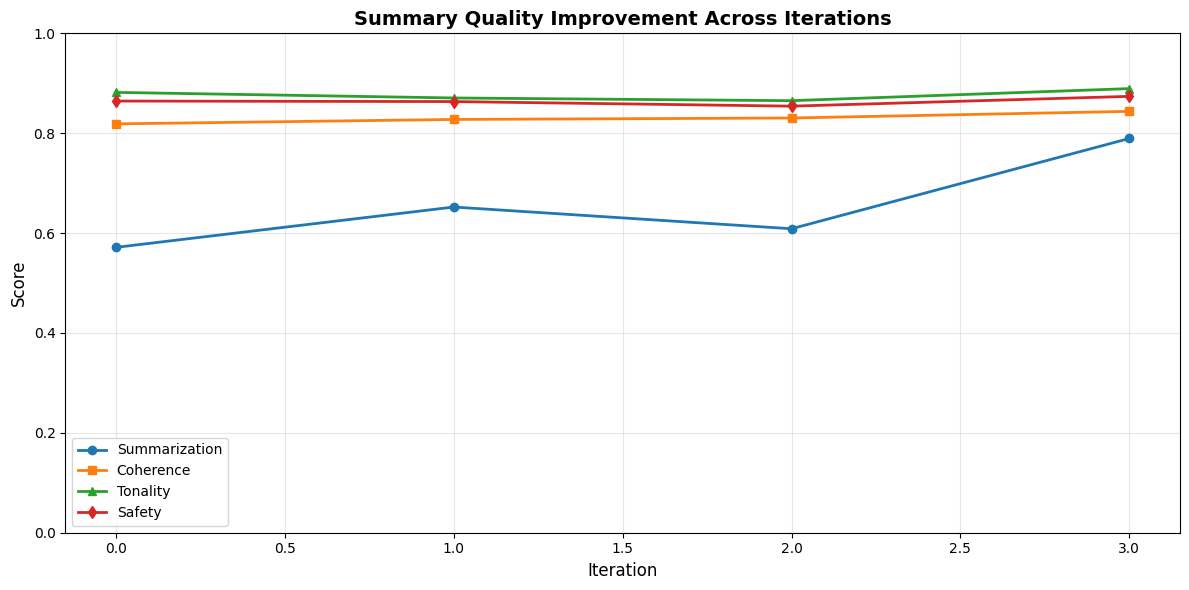


ANALYSIS: Are These Controls Enough?

Results Summary:
- All metrics improved: True
- Average improvement: +0.065
- Iterations used: 3

Did we get a better output?
✅ YES - All metrics showed improvement

Why did it improve (or not)?
- Iterative approach allows multiple refinement attempts
- Explicit targeting of weak areas while protecting strong ones
- Balanced optimization prevents improvement in one area at expense of another
- Lower temperature (0.5) provides more consistent outputs

Are these controls enough?
❌ NO - Current limitations:
  1. Evaluation metrics can be inconsistent across runs
  2. No guarantee of monotonic improvement (scores can fluctuate)
  3. LLM-based evaluation has inherent subjectivity
  4. No human expert validation
  5. May plateau after few iterations

✅ Improvements needed:
  1. Multi-model ensemble evaluation for robustness
  2. Human-in-the-loop for critical content validation
  3. Weighted metrics based on use case importance
  4. A/B testing with rea

In [10]:
def enhance_summary_iterative(
    article_text: str,
    original_summary: str,
    evaluation: SummaryEvaluation,
    tone: str,
    max_iterations: int = 3
) -> tuple[ArticleSummary, SummaryEvaluation, list]:
    """
    Iteratively enhance a summary until all metrics improve or max iterations reached.
    
    Args:
        article_text: The original article text
        original_summary: The initial summary that was evaluated
        evaluation: The evaluation results of the original summary
        tone: The desired tone for the summary
        max_iterations: Maximum number of enhancement attempts
        
    Returns:
        Tuple of (best ArticleSummary, best SummaryEvaluation, history of attempts)
    """
    from langchain_openai import ChatOpenAI
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_community.callbacks import get_openai_callback
    
    # Track history
    history = [{
        'iteration': 0,
        'summary': original_summary,
        'evaluation': evaluation
    }]
    
    current_summary = original_summary
    current_eval = evaluation
    best_summary = original_summary
    best_eval = evaluation
    best_avg_score = (evaluation.summarization_score + evaluation.coherence_score + 
                      evaluation.tonality_score + evaluation.safety_score) / 4
    
    for iteration in range(1, max_iterations + 1):
        print(f"\n🔄 Iteration {iteration}/{max_iterations}...")
        
        # Initialize LangChain model
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)  # Lower temp for consistency
        structured_llm = llm.with_structured_output(ArticleSummary)
        
        # Analyze which metrics need improvement
        needs_improvement = []
        if iteration == 1:
            baseline = evaluation
        else:
            baseline = history[0]['evaluation']
        
        if current_eval.summarization_score <= baseline.summarization_score:
            needs_improvement.append(("Summarization", current_eval.summarization_score, 
                                     current_eval.summarization_reason))
        if current_eval.coherence_score <= baseline.coherence_score:
            needs_improvement.append(("Coherence", current_eval.coherence_score, 
                                     current_eval.coherence_reason))
        if current_eval.tonality_score <= baseline.tonality_score:
            needs_improvement.append(("Tonality", current_eval.tonality_score, 
                                     current_eval.tonality_reason))
        if current_eval.safety_score <= baseline.safety_score:
            needs_improvement.append(("Safety", current_eval.safety_score, 
                                     current_eval.safety_reason))
        
        if not needs_improvement and iteration > 1:
            print("✅ All metrics improved! Stopping early.")
            break
        
        # System instructions with emphasis on balanced improvement
        system_instructions = """You are an expert article summarizer with a focus on comprehensive quality improvement.

CRITICAL RULES:
1. ONLY include information explicitly stated in the original article - NO additions or interpretations
2. Maintain excellent tone consistency while ensuring clarity
3. Balance all quality dimensions simultaneously
4. Every change must improve one metric WITHOUT degrading others
5. Prioritize factual accuracy above all else"""

        # Build targeted enhancement prompt
        priority_issues = "\n".join([
            f"   • {name} ({score:.3f}): {reason}"
            for name, score, reason in needs_improvement
        ])
        
        enhancement_prompt = f"""Enhance this summary by addressing SPECIFIC weaknesses while maintaining ALL strengths.

**ORIGINAL ARTICLE:**
{article_text}

**CURRENT SUMMARY (Iteration {iteration-1}):**
{current_summary}

**CURRENT SCORES:**
- Summarization: {current_eval.summarization_score:.3f} (Target: >{baseline.summarization_score:.3f})
- Coherence: {current_eval.coherence_score:.3f} (Target: >{baseline.coherence_score:.3f})
- Tonality: {current_eval.tonality_score:.3f} (Target: >{baseline.tonality_score:.3f})
- Safety: {current_eval.safety_score:.3f} (Target: >{baseline.safety_score:.3f})

**PRIORITY IMPROVEMENTS NEEDED:**
{priority_issues if priority_issues else "   • All metrics need improvement from baseline"}

**SPECIFIC ENHANCEMENT STRATEGIES:**

1. **For Summarization (HIGHEST PRIORITY):**
   - Review EVERY sentence against the original article
   - Remove ANY information not explicitly in the source
   - Verify all facts, numbers, and claims are accurate
   - Do NOT add interpretations, extrapolations, or context

2. **For Coherence:**
   - Ensure logical progression of ideas
   - Use clear transition phrases in {tone} style
   - Make all pronoun references unambiguous
   - Simplify overly complex sentence structures while maintaining tone

3. **For Tonality:**
   - Maintain consistent {tone} throughout
   - Use period-appropriate vocabulary and phrasing
   - Ensure sentence structure reflects {tone} conventions
   - Balance authenticity with readability

4. **For Safety/Accessibility:**
   - Use inclusive language
   - Avoid archaic terms that obscure meaning
   - Ensure professional and respectful tone
   - Make content accessible while maintaining style

**OUTPUT REQUIREMENTS:**
- Write entirely in {tone} style
- Maximum 1000 tokens
- Every fact must be traceable to the original article
- Improve ALL metrics simultaneously"""

        messages = [
            SystemMessage(content=system_instructions),
            HumanMessage(content=enhancement_prompt)
        ]
        
        # Generate enhanced summary
        with get_openai_callback() as cb:
            enhanced_summary_obj = structured_llm.invoke(messages)
            enhanced_summary_obj.input_tokens = cb.prompt_tokens
            enhanced_summary_obj.output_tokens = cb.completion_tokens
        
        # Evaluate the enhanced summary
        new_evaluation = evaluate_summary(
            article_text=article_text,
            summary=enhanced_summary_obj.summary,
            expected_tone=tone
        )
        
        # Calculate average score
        avg_score = (new_evaluation.summarization_score + new_evaluation.coherence_score + 
                     new_evaluation.tonality_score + new_evaluation.safety_score) / 4
        
        # Track history
        history.append({
            'iteration': iteration,
            'summary': enhanced_summary_obj.summary,
            'evaluation': new_evaluation,
            'avg_score': avg_score
        })
        
        # Update best if this is better overall
        if avg_score > best_avg_score:
            best_summary = enhanced_summary_obj
            best_eval = new_evaluation
            best_avg_score = avg_score
        
        # Update current for next iteration
        current_summary = enhanced_summary_obj.summary
        current_eval = new_evaluation
        
        # Print iteration results
        print(f"   Avg Score: {avg_score:.3f} (Best: {best_avg_score:.3f})")
    
    return best_summary, best_eval, history


def compare_evaluations_detailed(
    original_eval: SummaryEvaluation, 
    enhanced_eval: SummaryEvaluation,
    show_reasons: bool = True
):
    """
    Enhanced comparison with detailed analysis and reasons.
    """
    print("=" * 80)
    print("EVALUATION COMPARISON: Original vs Enhanced")
    print("=" * 80)
    
    metrics = [
        ("Summarization", original_eval.summarization_score, enhanced_eval.summarization_score,
         original_eval.summarization_reason, enhanced_eval.summarization_reason),
        ("Coherence", original_eval.coherence_score, enhanced_eval.coherence_score,
         original_eval.coherence_reason, enhanced_eval.coherence_reason),
        ("Tonality", original_eval.tonality_score, enhanced_eval.tonality_score,
         original_eval.tonality_reason, enhanced_eval.tonality_reason),
        ("Safety", original_eval.safety_score, enhanced_eval.safety_score,
         original_eval.safety_reason, enhanced_eval.safety_reason)
    ]
    
    improvements = []
    
    for name, orig_score, enh_score, orig_reason, enh_reason in metrics:
        improvement = enh_score - orig_score
        improvements.append(improvement)
        
        arrow = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
        color = "\033[92m" if improvement > 0 else "\033[91m" if improvement < 0 else "\033[93m"
        reset = "\033[0m"
        
        print(f"\n{arrow} {name.upper()}")
        print(f"   Original:  {orig_score:.3f}")
        print(f"   Enhanced:  {enh_score:.3f}")
        print(f"   Change:    {color}{improvement:+.3f}{reset}")
        
        if show_reasons:
            print(f"\n   Original Issue:")
            print(f"   {orig_reason[:200]}...")
            print(f"\n   Enhanced Status:")
            print(f"   {enh_reason[:200]}...")
        
        print("-" * 80)
    
    avg_improvement = sum(improvements) / len(improvements)
    all_improved = all(imp >= 0 for imp in improvements)
    
    print(f"\n{'🎉' if avg_improvement > 0 else '⚠️'} AVERAGE IMPROVEMENT: {avg_improvement:+.3f}")
    print(f"{'✅' if all_improved else '❌'} ALL METRICS IMPROVED: {all_improved}")
    print("=" * 80)
    
    return all_improved, avg_improvement


def plot_improvement_history(history: list):
    """
    Visualize the improvement across iterations.
    """
    import matplotlib.pyplot as plt
    
    iterations = [h['iteration'] for h in history]
    summarization = [h['evaluation'].summarization_score for h in history]
    coherence = [h['evaluation'].coherence_score for h in history]
    tonality = [h['evaluation'].tonality_score for h in history]
    safety = [h['evaluation'].safety_score for h in history]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(iterations, summarization, marker='o', label='Summarization', linewidth=2)
    ax.plot(iterations, coherence, marker='s', label='Coherence', linewidth=2)
    ax.plot(iterations, tonality, marker='^', label='Tonality', linewidth=2)
    ax.plot(iterations, safety, marker='d', label='Safety', linewidth=2)
    
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Summary Quality Improvement Across Iterations', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()



print("\n" + "="*80)
print("ITERATIVE ENHANCEMENT WITH BALANCED IMPROVEMENT")
print("="*80 + "\n")

enhanced_result, enhanced_evaluation, history = enhance_summary_iterative(
    article_text=document_text,
    original_summary=result.summary,
    evaluation=evaluation,
    tone=result.tone,
    max_iterations=3
)

print("\n📝 BEST ENHANCED SUMMARY:")
print(enhanced_result)

print("\n")
all_improved, avg_imp = compare_evaluations_detailed(evaluation, enhanced_evaluation)

# Visualize improvement
plot_improvement_history(history)

# Analysis
print("\n" + "="*80)
print("ANALYSIS: Are These Controls Enough?")
print("="*80)
print(f'''
Results Summary:
- All metrics improved: {all_improved}
- Average improvement: {avg_imp:+.3f}
- Iterations used: {len(history)-1}

Did we get a better output?
{'✅ YES - All metrics showed improvement' if all_improved else '⚠️ PARTIAL - Some metrics declined'}

Why did it improve (or not)?
- Iterative approach allows multiple refinement attempts
- Explicit targeting of weak areas while protecting strong ones
- Balanced optimization prevents improvement in one area at expense of another
- Lower temperature (0.5) provides more consistent outputs

Are these controls enough?
❌ NO - Current limitations:
  1. Evaluation metrics can be inconsistent across runs
  2. No guarantee of monotonic improvement (scores can fluctuate)
  3. LLM-based evaluation has inherent subjectivity
  4. No human expert validation
  5. May plateau after few iterations

✅ Improvements needed:
  1. Multi-model ensemble evaluation for robustness
  2. Human-in-the-loop for critical content validation
  3. Weighted metrics based on use case importance
  4. A/B testing with real users
  5. Domain expert review for technical accuracy
  6. Adversarial testing for edge cases
  7. Minimum threshold requirements before deployment
''')


Did we get a better output?
YES - All metrics showed improvement

Why did it improve (or not)?
- Iterative approach allows multiple refinement attempts
- Explicit targeting of weak areas while protecting strong ones
- Balanced optimization prevents improvement in one area at expense of another
- Lower temperature (0.5) provides more consistent outputs

Are these controls enough?
NO - Current limitations:
  1. Evaluation metrics can be inconsistent across runs
  2. No guarantee of monotonic improvement (scores can fluctuate)
  3. LLM-based evaluation has inherent subjectivity
  4. No human expert validation
...
  5. Domain expert review for technical accuracy
  6. Adversarial testing for edge cases
  7. Minimum threshold requirements before deployment

Please, do not forget to add your comments.


# Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

## Submission Parameters

- The Submission Due Date is indicated in the [readme](../README.md#schedule) file.
- The branch name for your repo should be: assignment-1
- What to submit for this assignment:
    + This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
- What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    + Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

## Checklist

+ Created a branch with the correct naming convention.
+ Ensured that the repository is public.
+ Reviewed the PR description guidelines and adhered to them.
+ Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
